# Assumptions

- an increase in heart rate has a linear effect on the fluid flow (high BPM will in reality have limited/not have any flow)
- standard pressure readings of 120/80 (pressure can influence velocity)
- cardiac function is normal (no reduced bloodflow due to poor cardiac function)
- blood viscosity is standard (3.3e-6 ms-1)
- inflow velocity flows exactly the profiles plotted below (criticism - twists and bends of fluid flow may influence incidental velocity on aneurysm. try to have more initial vascular structure to help mitigate this) 
- const temp of 37 degress across the body
- low reynonds numbers as a result of lower characteristic lengths


might be possible to model bloodflow as a function dependant on the vascular structure (Patient-Specific Data: Use PC-MRI velocity profiles if available)




## plan for viscocity-based models
- XLB already uses the relaxation paramter. based off kinematic viscocity which itself is based off the dynamic viscocity and density
- thus therefore, assumes a newtonian properties of fluid (blood) across the entire blood vessel 
- model non-newutonian fluid by taking the viscocity and scaling the velocity based off 1/ viscocity, or something like that
- look at carreau yaskuda and that paper for ideal model params

## plan for inflow vleocity based models
- at the inflow bc, cycle that sinusodial like flow on a per second basis. have 2 flows for ICA and CA

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Example usage - Standard inflow parameters
standard_inflow_params = {
    'u_max': 0.4,                # Maximum velocity base (m/s)
    'dt': 5e-7,                   # Time step (seconds)
    'heart_rate': 60,             # Heart rate in beats per minute (60 BPM = 1 Hz)
    'time_range': (0, 2.0),       # Time range to plot (seconds)
    'num_points': 5000,           # Number of points for plotting
    'min_inflow_velocity': 1.0,   # Minimum inflow velocity factor (1.0 = u_max when sin=0)
    'amplitude': 1.0              # Amplitude scaling
}

In [6]:
def plot_profile(data):
    """
    Create a plot of viscosity profile or velocity profile
    
    Parameters:
        data: Dictionary from calculate_carreau_data, calculate_carreau_yasuda_data,
              or calculate_sinusoidal_data
    Returns:
        Matplotlib figure object
    """
    plot_params = data['plot_config']
    figsize = plot_params.get('figsize', (10, 6))
    title = plot_params.get('title', 'Profile')
    save_path = plot_params.get('save_path', None)
    dpi = plot_params.get('dpi', 300)
    color = plot_params.get('color', 'blue')
    xscale = plot_params.get('xscale', 'linear')
    yscale = plot_params.get('yscale', 'linear')
    grid = plot_params.get('grid', True)
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determine model type
    model_type = data.get('model_type', 'unknown')
    
    # Check if this is a viscosity model (Carreau or Carreau-Yasuda)
    if 'shear_rate' in data:
        # Common setup for viscosity models
        x = data['shear_rate']
        
        # Get viscosity data (handle different keys for different models)
        if 'dynamic_viscosity' in data:
            y = data['dynamic_viscosity']
            viscosity_type = 'Dynamic Viscosity'
        else:
            y = data['viscosity']
            viscosity_type = 'Viscosity'
            
        ax.plot(x, y, color=color, lw=2)
        ax.set_xlabel('Shear Rate (s⁻¹)')
        ax.set_ylabel(f'{viscosity_type} (Pa·s)')
        
        # Add reference lines for zero and infinite shear
        ax.axhline(y=data['eta_zero'], linestyle='--', color='gray', alpha=0.7, 
                   label=f'Zero Shear: {data["eta_zero"]:.4f} Pa·s')
        ax.axhline(y=data['eta_inf'], linestyle='--', color='black', alpha=0.7,
                   label=f'Infinite Shear: {data["eta_inf"]:.4f} Pa·s')
        
        # Add physiological range indicator if available
        if 'physiological_range' in data:
            physio_min, physio_max = data['physiological_range']
            ax.axvspan(physio_min, physio_max, alpha=0.15, color='green',
                     label=f'Physiological Range ({physio_min}-{physio_max} s⁻¹)')
        
        # Add equation annotation with proper model name
        model_name = "Carreau-Yasuda" if model_type == 'carreau-yasuda' else "Carreau"
        ax.text(0.5, 0.05, f"{model_name} Model: {data['equation']}", 
                transform=ax.transAxes, ha='center', va='bottom',
                bbox=dict(facecolor='white', alpha=0.8))
        
    else:
        # Sinusoidal flow plot (original function)
        x = data['time']
        y = data['velocity']
        ax.plot(x, y, color=color, 
                label=f'u_max * ({data["equation"]})')
                
        # Add period lines if specified
        if data['plot_config'].get('show_period_lines', False):
            period = data['period']
            for i in range(int(x[-1] / period) + 1):
                if i * period >= x[0] and i * period <= x[-1]:
                    ax.axvline(x=i*period, color='gray', linestyle=':', alpha=0.5)
        
        # Add heart rate annotation if this is a cardiac flow model
        if data['plot_config'].get('show_bpm_annotation', False) and 'heart_rate' in data:
            max_y = data.get('max_velocity', np.max(y))
            ax.text(0.5 * (x[0] + x[-1]), 0.9 * max_y, 
                    f"Heart Rate: {data['heart_rate']} BPM", 
                    horizontalalignment='center', 
                    bbox=dict(facecolor='white', alpha=0.8))
    
    # Set scales
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    # Labels and formatting
    ax.set_title(title)
    if grid:
        ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=dpi)
    
    return fig

def print_simulation_stats(data):
    """Print statistics about the simulation data"""
    # Determine model type
    model_type = data.get('model_type', 'unknown')
    
    # Determine data type and print appropriate statistics
    if 'shear_rate' in data:
        # Handle both Carreau and Carreau-Yasuda models
        model_name = "Carreau-Yasuda" if model_type == 'carreau-yasuda' else "Carreau"
        print(f"--- Blood Viscosity: {model_name} Model ---")
        print(f"Zero shear viscosity (η₀): {data['eta_zero']:.6f} Pa·s")
        print(f"Infinite shear viscosity (η∞): {data['eta_inf']:.6f} Pa·s")
        print(f"Time constant (λ): {data['lambda']:.4f} s")
        print(f"Power law index (n): {data['n']:.4f}")
        
        # Display Yasuda parameter if present
        if 'a' in data:
            print(f"Yasuda parameter (a): {data['a']:.4f}")
            
        print(f"Shear rate range: {data['shear_rate'].min():.2f} to {data['shear_rate'].max():.2f} s⁻¹")
        
        # Handle different viscosity outputs
        if 'dynamic_viscosity' in data:
            print(f"Dynamic viscosity range: {data['dynamic_viscosity'].min():.6f} to {data['dynamic_viscosity'].max():.6f} Pa·s")
            if 'kinematic_viscosity' in data:
                print(f"Kinematic viscosity range: {data['kinematic_viscosity'].min():.8f} to {data['kinematic_viscosity'].max():.8f} m²/s")
        else:
            print(f"Viscosity range: {data['viscosity'].min():.6f} to {data['viscosity'].max():.6f} Pa·s")
            
        print(f"Model equation: {data['equation']}")
    else:
        # Sinusoidal flow
        print(f"--- Sinusoidal Flow Profile Statistics ---")
        print(f"Oscillation period: {data['period']:.4f} seconds")
        print(f"Heart Rate: {data['heart_rate']} BPM")
        print(f"Frequency: {data['frequency']:.4f} Hz")
        print(f"Timesteps per oscillation: {data['timesteps_per_period']:.2f}")
        print(f"Velocity range: {data.get('min_velocity', 'N/A')} to {data.get('max_velocity', 'N/A')} m/s")

--- Sinusoidal Flow Profile Statistics ---
Oscillation period: 1.0000 seconds
Heart Rate: 60 BPM
Frequency: 1.0000 Hz
Timesteps per oscillation: 2000000.00
Velocity range: 0 to 0.8 m/s


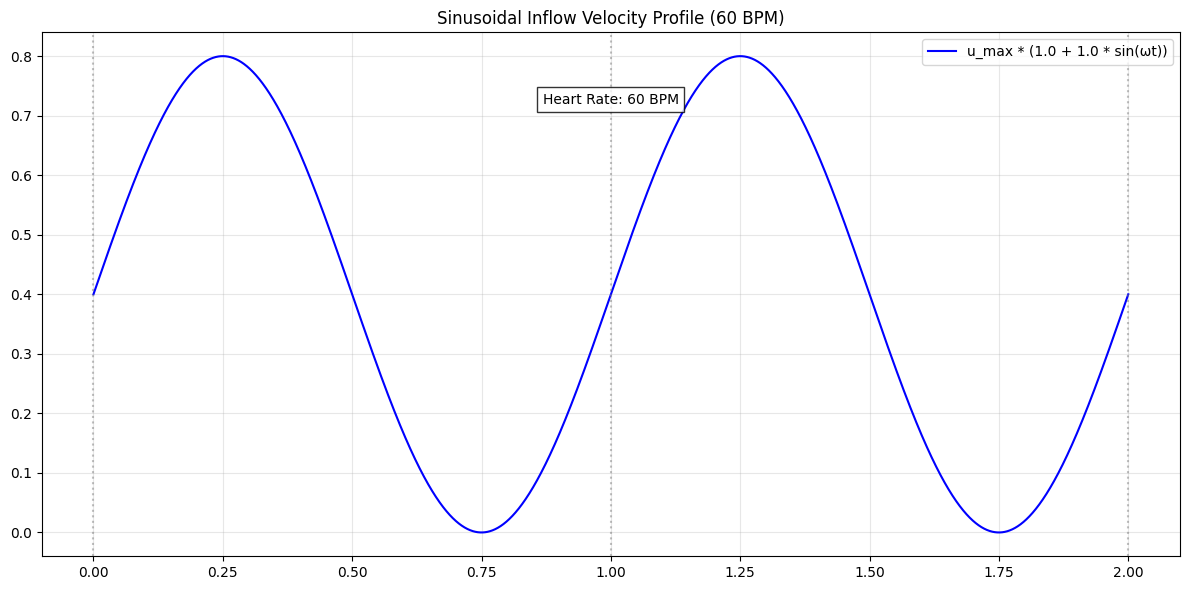

In [7]:
def calculate_sinusoidal_data(params):
    """
    Calculate velocity data for a sinusoidal inflow profile
    
    Parameters:
        params: dict containing velocity profile parameters
    Returns:
        Dictionary with time arrays, velocity data and plot configuration
    """
    # Extract parameters
    u_max = params['u_max']
    dt = params['dt']
    heart_rate = params['heart_rate']  # Heart rate in BPM
    time_range = params['time_range']
    num_points = params['num_points']
    min_inflow_velocity = params.get('min_inflow_velocity', 1.0)
    amplitude = params.get('amplitude', 1.0)
    
    # Convert heart rate to frequency in Hz
    frequency = heart_rate / 60.0  # BPM to Hz conversion
    
    # Calculate derived values
    omega = 2.0 * np.pi * frequency
    period = 1.0 / frequency
    t = np.linspace(time_range[0], time_range[1], num_points)
    
    # Calculate velocity
    u = u_max * (min_inflow_velocity + amplitude * np.sin(omega * t))
    
    # Calculate min and max velocities
    min_velocity = u_max * (min_inflow_velocity - amplitude) if min_inflow_velocity > amplitude else 0
    max_velocity = u_max * (min_inflow_velocity + amplitude)
    
    # Default plot configuration
    plot_config = {
        'title': f'Sinusoidal Inflow Velocity Profile ({heart_rate} BPM)',
        'save_path': f'cardiac_inflow_{heart_rate}bpm.png',
        'dpi': 300,
        'show_period_lines': True if heart_rate <= 200 else False,
        'show_bpm_annotation': True,
        'color': 'blue',
        'figsize': (12, 6)
    }
    
    return {
        'time': t,
        'velocity': u,
        'period': period,
        'frequency': frequency,
        'heart_rate': heart_rate,
        'min_velocity': min_velocity,
        'max_velocity': max_velocity,
        'timesteps_per_period': period / dt,
        'equation': f"{min_inflow_velocity} + {amplitude} * sin(ωt)",
        'plot_config': plot_config  # Include plot config in the data
    }



# Calculate data (now includes plot configuration)
inflow_data = calculate_sinusoidal_data(standard_inflow_params)

inflow_data["plot_config"]["save_path"] = False

# Generate plot with a single parameter
fig = plot_profile(inflow_data)

# Print statistics
print_simulation_stats(inflow_data)

--- Blood Viscosity: Carreau Model ---
Zero shear viscosity (η₀): 0.056000 Pa·s
Infinite shear viscosity (η∞): 0.003500 Pa·s
Time constant (λ): 3.3130 s
Power law index (n): 0.3568
Shear rate range: 0.01 to 10000.00 s⁻¹
Viscosity range: 17.863050 to 280.506798 Pa·s
Model equation: η = 0.0035 + (0.0560 - 0.0035)[1 + (3.313·γ̇)²]^(-0.3216)


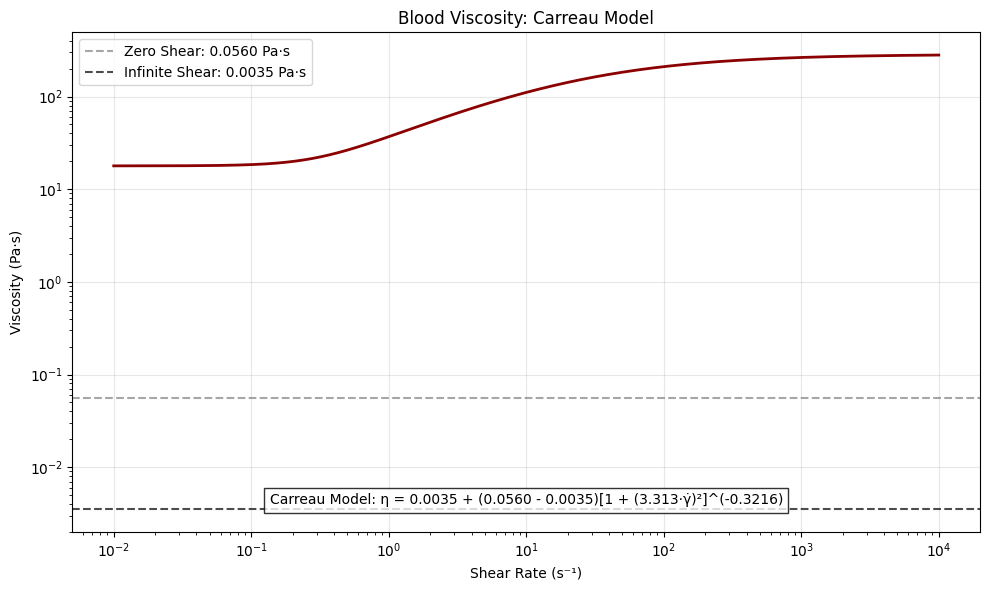

In [8]:
def calculate_carreau_data(params):
    """
    Calculate viscosity data using the Carreau model for blood
    
    Parameters:
        params: dict containing Carreau model parameters
    Returns:
        Dictionary with shear rate data, viscosity, and plot configuration
    """
    # Extract parameters
    shear_rate_range = params.get('shear_rate_range', (0.01, 10000))  # Range of shear rates (s^-1)
    num_points = params.get('num_points', 1000)                      # Number of data points
    
    # Carreau model 
    eta_zero = params.get('eta_zero', 0.056)      # Zero shear viscosity (Pa·s)
    eta_inf = params.get('eta_inf', 0.0035)       # Infinite shear viscosity (Pa·s) 
    lambda_time = params.get('lambda', 3.313)     # Time constant (s)
    n = params.get('n', 0.3568)                   # Power law index
    
    # Generate shear rate data points (logarithmic scale is usually better for this)
    shear_rate = np.logspace(np.log10(shear_rate_range[0]), 
                             np.log10(shear_rate_range[1]), 
                             num_points)
    
    # Calculate viscosity using Carreau model
    viscosity = eta_inf + (eta_zero - eta_inf) * (1 + (lambda_time * shear_rate)**2)**((n-1)/2)
    
    # Default plot configuration
    plot_config = {
        'title': 'Blood Viscosity: Carreau Model',
        'save_path': 'blood_viscosity_carreau.png',
        'dpi': 300,
        'color': 'darkred',
        'figsize': (10, 6),
        'xscale': 'log',  # Logarithmic x-axis for better visualization
        'yscale': 'log',  # Logarithmic y-axis for better visualization
        'grid': True
    }
    
    # Create the model equation as string for display
    equation = f"η = {eta_inf:.4f} + ({eta_zero:.4f} - {eta_inf:.4f})[1 + ({lambda_time:.3f}·γ̇)²]^({(n-1)/2:.4f})"
    
    return {
        'shear_rate': shear_rate,
        'viscosity': 1/viscosity,    # Convert to kineitc viscosity
        'eta_zero': eta_zero,
        'eta_inf': eta_inf, 
        'lambda': lambda_time,
        'n': n,
        'equation': equation,
        'plot_config': plot_config
    }


# Calculate data for Carreau model
viscosity_data = calculate_carreau_data(standard_inflow_params)

# Generate plot
fig = plot_profile(viscosity_data)

# Print statistics
print_simulation_stats(viscosity_data)

--- Blood Viscosity: Carreau-Yasuda Model ---
Zero shear viscosity (η₀): 0.160000 Pa·s
Infinite shear viscosity (η∞): 0.003500 Pa·s
Time constant (λ): 8.2000 s
Power law index (n): 0.2128
Yasuda parameter (a): 2.0000
Shear rate range: 0.00 to 10000.00 s⁻¹
Dynamic viscosity range: 0.003521 to 0.159996 Pa·s
Kinematic viscosity range: 0.00000333 to 0.00015151 m²/s
Model equation: η = 0.0035 + (0.1600 - 0.0035)[1 + (8.200·γ̇)^2.000]^(-0.3936)


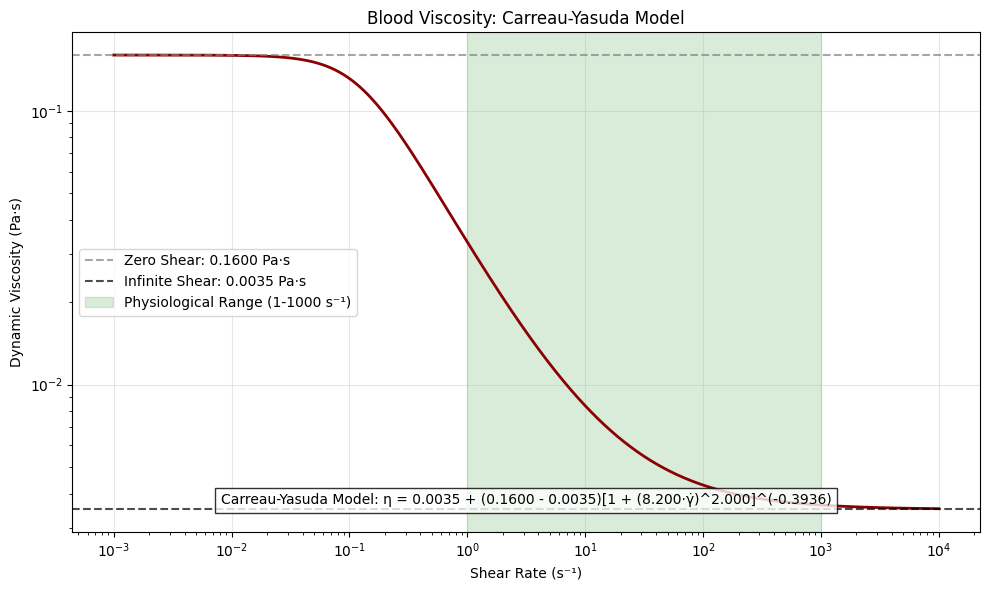

In [9]:
def calculate_carreau_yasuda_data(params):
    """
    Calculate viscosity data using the Carreau-Yasuda model for blood
    
    Parameters:
        params: dict containing Carreau-Yasuda model parameters
    Returns:
        Dictionary with shear rate data, viscosity, and plot configuration
    """
    # Extract parameters
    shear_rate_range = params.get('shear_rate_range', (0.01, 10000))  # Range of shear rates (s^-1)
    num_points = params.get('num_points', 1000)                      # Number of data points
    blood_density = params.get('blood_density', 1056)                # Blood density (kg/m³)
    
    # Carreau-Yasuda model parameters
    eta_zero = params.get('eta_zero', 0.022)      # Zero shear viscosity (Pa·s)
    eta_inf = params.get('eta_inf', 0.0022)       # Infinite shear viscosity (Pa·s)
    lambda_time = params.get('lambda', 0.110)     # Time constant (s)
    n = params.get('n', 0.392)                    # Power law index
    a = params.get('a', 0.644)                    # Yasuda parameter (transition sharpness)
    
    # Generate shear rate data points (logarithmic scale)
    shear_rate = np.logspace(np.log10(shear_rate_range[0]), 
                             np.log10(shear_rate_range[1]), 
                             num_points)
    
    # Calculate dynamic viscosity using Carreau-Yasuda model
    dyn_viscosity = eta_inf + (eta_zero - eta_inf) * (1 + (lambda_time * shear_rate)**a)**((n-1)/a)
    
    # Calculate kinematic viscosity if needed
    kin_viscosity = dyn_viscosity / blood_density
    
    # Default plot configuration
    plot_config = {
        'title': 'Blood Viscosity: Carreau-Yasuda Model',
        'save_path': 'blood_viscosity_carreau_yasuda.png',
        'dpi': 300,
        'color': 'darkred',
        'figsize': (10, 6),
        'xscale': 'log',
        'yscale': 'log',
        'grid': True
    }
    
    # Create the model equation as string for display
    equation = f"η = {eta_inf:.4f} + ({eta_zero:.4f} - {eta_inf:.4f})[1 + ({lambda_time:.3f}·γ̇)^{a:.3f}]^({(n-1)/a:.4f})"
    
    return {
        'model_type': 'carreau-yasuda',
        'shear_rate': shear_rate,
        'dynamic_viscosity': dyn_viscosity,      # Dynamic viscosity (Pa·s)
        'kinematic_viscosity': kin_viscosity,    # Kinematic viscosity (m²/s)
        'blood_density': blood_density,          # Blood density (kg/m³)
        'eta_zero': eta_zero,
        'eta_inf': eta_inf, 
        'lambda': lambda_time,
        'n': n,
        'a': a,                                  # Additional Yasuda parameter
        'equation': equation,
        'physiological_range': (1, 1000),        # Typical physiological shear rate range
        'plot_config': plot_config
    }

# Example usage:
# https://www.jafmonline.net/article_840_f9c1e51abb28c2a495f33c65e0a49ae7.pdf. Needs source and ref and read thru
carreau_yasuda_params = {
    'num_points': 1000,
    'shear_rate_range': (0.001, 10000),
    'eta_zero': 0.16,         # Zero shear viscosity (Pa·s)
    'eta_inf': 0.0035,        # Infinite shear viscosity (Pa·s)
    'lambda': 8.2,            # Time constant (s)
    'n': 0.2128,              # Power law index
    'a': 2.0,                 # Yasuda parameter
    'blood_density': 1056     # Blood density (kg/m³)
}

# Calculate data using Carreau-Yasuda model
viscosity_data = calculate_carreau_yasuda_data(carreau_yasuda_params)

# Generate plot
fig = plot_profile(viscosity_data)

# Print statistics
print_simulation_stats(viscosity_data)